In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Dataset
data_path = r"/content/drive/MyDrive/Colab Notebooks/spam.csv"

In [4]:
df = pd.read_csv(data_path)

In [5]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [7]:
df.isnull().sum()

,0
Category,0
Message,0


In [8]:
duplicate_count = int(df.duplicated().sum())
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 415


In [9]:
df[df.duplicated()]

,Category,Message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [10]:
df.drop_duplicates(subset='Message', inplace=True)

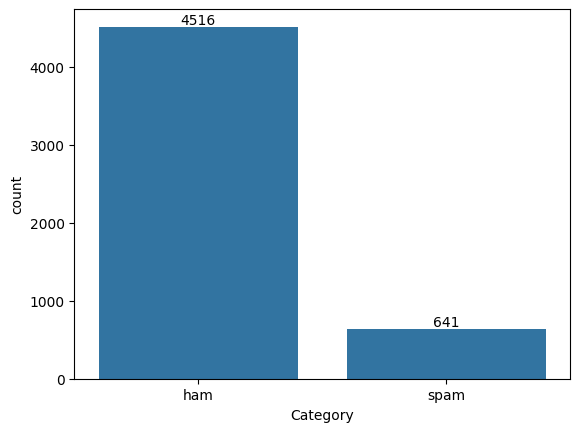

In [11]:
ax = sns.countplot(data=df, x='Category')

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 30, int(height), ha='center')
plt.show()

In [12]:
# Convert labels to binary
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [13]:
import re
import nltk
from nltk.corpus import stopwords

In [14]:
# Initialize NLP tools
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z!?'\s]", "", text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

In [16]:
df['Processed_Message'] = df['Message'].apply(preprocess_text)

In [17]:
df.head()

,Category,Message,Processed_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Processed_Message'])
y = df['Category']

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [22]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
# Apply SMOTE for balancing dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [25]:
# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.1, 0.5, 1, 5, 10]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10]}, scoring='accuracy')

In [26]:
# Train best model
best_model = grid_search.best_estimator_

In [27]:
# Predictions
y_pred = best_model.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [29]:
# Evaluation
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'C': 10}
Model Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       896
           1       0.91      0.91      0.91       136

    accuracy                           0.98      1032
   macro avg       0.95      0.95      0.95      1032
weighted avg       0.98      0.98      0.98      1032

Confusion Matrix:
 [[883  13]
 [ 12 124]]


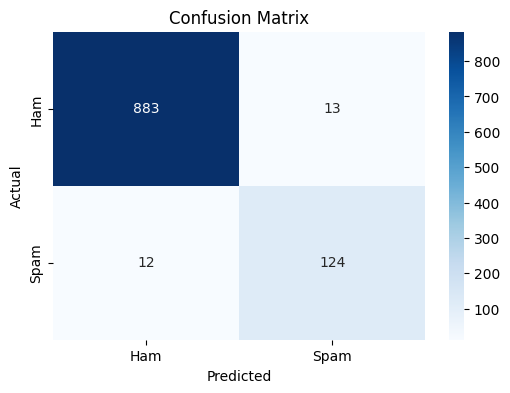

In [30]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
import joblib

In [32]:
# Save model and vectorizer together
joblib.dump((best_model, vectorizer), "spam_ham_classifier.pkl")

['spam_ham_classifier.pkl']